In [85]:
import ROOT
import numpy as np

In [86]:
def linspace(start, end, steps):
    values = []
    for i in range(steps):
        values.append(start + i*(end-start)/(steps-1))
    return values

[50.0, 55.26315789473684, 60.526315789473685, 65.78947368421052, 71.05263157894737, 76.3157894736842, 81.57894736842105, 86.84210526315789, 92.10526315789474, 97.36842105263159, 102.63157894736841, 107.89473684210526, 113.15789473684211, 118.42105263157895, 123.6842105263158, 128.94736842105263, 134.21052631578948, 139.4736842105263, 144.73684210526318, 150.0]
[0.0, 3.1578947368421053, 6.315789473684211, 9.473684210526315, 12.631578947368421, 15.789473684210526, 18.94736842105263, 22.105263157894736, 25.263157894736842, 28.42105263157895, 31.57894736842105, 34.73684210526316, 37.89473684210526, 41.05263157894737, 44.21052631578947, 47.36842105263158, 50.526315789473685, 53.68421052631579, 56.8421052631579, 60.0]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: I dont even know where this will show up


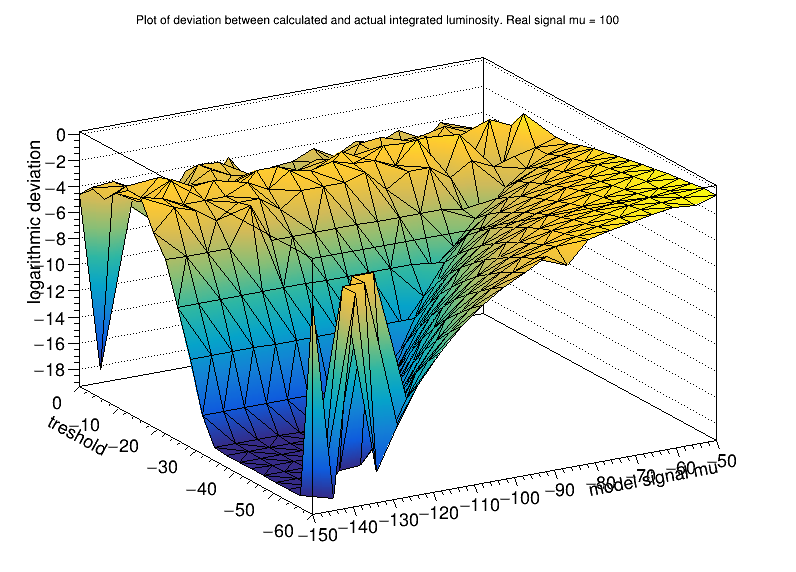

In [88]:
mu_collisions_per_BC = 200 #The parameter mu that is the expectation value of collisions per BC, which can be altered manually

real_signal_mu = 100
real_signal_sigma = 20

model_signal_mu_spread_interval_length = 50 * 2
model_signal_mu_step_count = 20

model_signal_mus = linspace(real_signal_mu-model_signal_mu_spread_interval_length/2, real_signal_mu + model_signal_mu_spread_interval_length/2, model_signal_mu_step_count)
model_signal_sigma = real_signal_sigma

treshold_lower = 0
treshold_upper = 60
treshold_step_count = 20
treshold_values =  linspace(treshold_lower, treshold_upper, treshold_step_count)

noise_mu = 0
noise_sigma = 5

print(model_signal_mus)
print(treshold_values)

model_noise = ROOT.TF1("ElecNoiseBg", "TMath::Gaus(x, %f, %f)" % (noise_mu, noise_sigma), -100, 500)
model_noise.SetNpx(10000)


"""
# more paramaters
simulation_time = 1 #seconds
bunch_crossings_per_second = 40 * 1e6
collisions_per_bunch_crossing = en fördelning
particles_per_collision = en fördelning
particles_reaching_the_sensor = en fördelning vi inte känner till och inte är vår uppgift att känna till
 
"""

prng = ROOT.TRandom3(123)

error_against_mu_treshold_plot = ROOT.TGraph2D()         #Function for plotting the deviation between the calculated integrated luminosity and the actual integrated luminosity, as a function of the parameter mu in the energy landau distribution and the treshold
error_against_mu_treshold_logplot = ROOT.TGraph2D()
point_index = 0

for model_signal_mu in model_signal_mus:
    model_signal = ROOT.TF1("Signal", "TMath::Landau(x, %f, %f)" % (model_signal_mu, model_signal_sigma), -100, 500)
    model_signal.SetNpx(10000)
    for treshold_value in treshold_values:
        model_expected_signal_above = 1 - model_signal.Integral(-100, treshold_value)/model_signal.Integral(-100, 500)
        model_expected_noise_above = 1 - model_noise.Integral(-100, treshold_value)/model_noise.Integral(-100, 500)
        #print("Model expected signal above " + str(model_expected_signal_above))
        #print("Model expected noise above " + str(model_expected_noise_above))
        
        event_count = 10000
        event_ratio = mu_collisions_per_BC * 10**(-5)  #The fraction of signals resulting from particles passing through the HGAD and from noise. See my notes for how i calculated it
        signal_count = int(round(event_count * event_ratio))
        noise_count = event_count - signal_count

        noise_above_count = 0
        signal_above_count = 0

        for i in range(signal_count):
            signal = prng.Landau(real_signal_mu, real_signal_sigma)
            if signal > treshold_value:
                signal_above_count += 1

        for i in range(noise_count):
            noise = prng.Gaus(noise_mu, noise_sigma)
            if noise > treshold_value:
                noise_above_count += 1
                
        total_above_count = noise_above_count + signal_above_count
        
        """
        Antag att vi vet:
            total_above_count
            event_ratio
            model_expected_signal_above
            model_expected_noise_above
        
        Hur ska vi räkna?
        Vi vill beräkna ett värde som är så nära signal_count som möjligt.
        """
        #First method of computing signal count we used, which assumes we know event_ratio
        total_count = total_above_count/(event_ratio*model_expected_signal_above + (1-event_ratio)*model_expected_noise_above)
        computed_signal_count = total_count*event_ratio
        
        #New method of computing signal count, which doesn't assume we know event ratio
        new_computed_signal_count = total_above_count/model_expected_signal_above
        
        # Compare with signal_count which is the correct value
        #print([model_signal_mu, treshold_value])
        #print("Computed signal above over signal count assuming we know event_ratio: " + str(computed_signal_count/signal_count))
        #print("Total above over signal count " + str(total_above_count/signal_count))
        #print("Computed signal above over signal count NOT assuming we know event_ratio: " + str(new_computed_signal_count/signal_count))
        
        #TFor the plot
        deviation = computed_signal_count/signal_count      #Calculate the deviation with both ways of computing the integrated luminosity
        alt_deviation = new_computed_signal_count/signal_count
        
        log_deviation = np.log(0.00000001 + abs(1 - computed_signal_count/signal_count))      #Also calculating the log of the deviation
        alt_log_deviation = np.log(0.00000001 + abs(1 - new_computed_signal_count/signal_count))
        
        error_against_mu_treshold_plot.SetPoint(point_index, model_signal_mu, treshold_value, alt_deviation)           #Adding data to both the logarithmic and non-logarithmic plot
        error_against_mu_treshold_logplot.SetPoint(point_index, -model_signal_mu, -treshold_value, log_deviation)   #I made the mu and treshold values negative to "flip" the axes in the plot for better visual inspection
        
        point_index += 1
        
        
#Försök till plot (just nu kan man bara plotta antingen log plotten eller icke-log plotten)        
canvas = ROOT.TCanvas("I dont even know where this will show up", "not this either", 800, 600)
#error_against_mu_treshold_plot.Draw("TRI1")
error_against_mu_treshold_logplot.Draw("TRI1")
#error_against_mu_treshold_plot.SetTitle("Plot of deviation between calculated and actual integrated luminosity. Real sigma mu = "+ str(real_signal_mu) + "; model sigma mu; treshold; deviation");
error_against_mu_treshold_logplot.SetTitle("Plot of deviation between calculated and actual integrated luminosity. Real signal mu = "+ str(real_signal_mu) + "; model signal mu; treshold; logarithmic deviation");

canvas.Draw()
